In [1]:
import cv2
#starting camera

cap=cv2.VideoCapture(0)
# 0 means using the first camera

#to check camera is open
if cap.isOpened():
    print("camera is working")
else:
    print("problem in opening camera")      


#now taking and reading input from camera
#print(cap.sum())  #this will take an image and gives the output in numpy 3d array

status,img=cap.read()  #it will take a picture

#now showing
cv2.imshow('liveshow',img)

#now writing ans saving the image taken

cv2.imwrite('C:/Users/user/Downloads/week3/img/new1.jpg',img)

#wait for window to close
cv2.waitKey(2)   #mili/micro seconds   ---- if given 0 then image wait for infinite time till we stop it
cv2.destroyAllWindows()
#to close camera
cap.release()

'import cv2\n#starting camera\n\ncap=cv2.VideoCapture(0)\n# 0 means using the first camera\n\n#to check camera is open\nif cap.isOpened():\n    print("camera is working")\nelse:\n    print("problem in opening camera")      \n\n\n#now taking and reading input from camera\n#print(cap.sum())  #this will take an image and gives the output in numpy 3d array\n\nstatus,img=cap.read()  #it will take a picture\n\n#now showing\ncv2.imshow(\'liveshow\',img)\n\n#now writing ans saving the image taken\n\ncv2.imwrite(\'C:/Users/user/Downloads/week3/img/new1.jpg\',img)\n\n#wait for window to close\ncv2.waitKey(2)   #mili/micro seconds   ---- if given 0 then image wait for infinite time till we stop it\ncv2.destroyAllWindows()\n#to close camera\ncap.release()'

In [2]:
pwd

'C:\\Users\\user'

In [3]:
cd Downloads/

C:\Users\user\Downloads


In [4]:
pwd

'C:\\Users\\user\\Downloads'

In [5]:
cd week3

C:\Users\user\Downloads\week3


In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


In [7]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores,-1)
    box_class_scores = K.max(box_scores,-1)
    filtering_mask = box_class_scores>threshold
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    return scores, boxes, classes

In [8]:
def iou(box1, box2):
    xi1 = max(box1[0],box2[0])
    yi1 = max(box1[1],box2[1])
    xi2 = min(box1[2],box2[2])
    yi2 = min(box1[3],box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
    return iou

In [9]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

In [10]:
yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                   tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))

In [11]:
yolo_outputs

(<tf.Tensor 'random_normal:0' shape=(19, 19, 5, 1) dtype=float32>,
 <tf.Tensor 'random_normal_1:0' shape=(19, 19, 5, 2) dtype=float32>,
 <tf.Tensor 'random_normal_2:0' shape=(19, 19, 5, 2) dtype=float32>,
 <tf.Tensor 'random_normal_3:0' shape=(19, 19, 5, 80) dtype=float32>)

In [12]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [13]:
scores, boxes, classes = yolo_eval(yolo_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
with tf.Session() as test_b:
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54


In [15]:
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

yolo_model = load_model("model_data/yolo.h5")

c:\python\python37\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


In [17]:
def predict(sess, image_file):
    image, image_data = preprocess_image("img/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)

    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)

    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))

    plt.figure(figsize=(12,12))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [18]:
img = plt.imread('img/dog.jpg')
image_shape = float(img.shape[0]), float(img.shape[1])
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Found 10 boxes for traffic.jpg
car 0.60 (61, 116) (131, 177)
car 0.62 (189, 85) (244, 114)
car 0.63 (116, 18) (150, 47)
car 0.63 (169, 104) (232, 161)
car 0.66 (88, 61) (139, 97)
car 0.66 (189, 131) (277, 176)
car 0.66 (44, 101) (111, 148)
car 0.66 (87, 81) (134, 122)
car 0.68 (238, 50) (280, 88)
car 0.70 (2, 81) (40, 134)


c:\python\python37\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


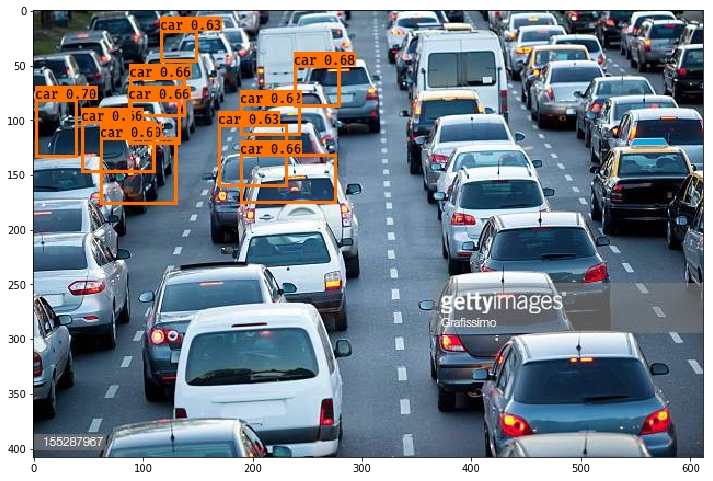

In [ ]:
out_scores, out_boxes, out_classes = predict(sess, "traffic.jpg")

In [ ]:
out_scores

array([0.7035176 , 0.6847681 , 0.66443264, 0.6583238 , 0.6557439 ,
       0.6551514 , 0.62791926, 0.62559205, 0.61731684, 0.60210776],
      dtype=float32)

In [ ]:
cars=len(out_scores)

In [ ]:
cars

10

In [ ]:
if cars>20:
    print("Its high traffic there....Sending Notification to the traffic police manager!!!!")
    # importing library
    import smtplib

    # taking input from user about sender email and password also receiver address
    add=input("Enter your gmail : \n")
    passw=input("Enter your pass : \n")
    to=input("Enter receiver email : \n")
    msg=input("Enter your msg : ")

    # setting smtp protocol
    ms=smtplib.SMTP('smtp.gmail.com',587)
    ms.starttls()

    # login into sender account
    ms.login(add,passw)
    # sending mail to receiver
    ms.sendmail(add,to,msg)

    print("\n ..sent !!")

    # logout from the server and quit the connection
    ms.quit()
else:
    print("Not enough traffic....!!!")

Its high traffic there....Sending Notification to the traffic police manager!!!!
